In [1]:
import pandas as pd
import re
import os
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

In [41]:
# clinvar
clinvarTSV = pd.read_csv('/home/vpt/data/clinvar/clinvar_tsv20190624/clinvar_variant_summary_20190624.txt.gz',sep = '\t')

#omim
genmap2 = pd.read_csv('/home/vpt/data/omim/20190718/genemap2.txt',sep ='\t',skiprows=3,dtype={'Entrez Gene ID':str,'Mim Number':str})
genmap2['Mim Number'] = 'OMIM:'+genmap2['Mim Number']
autosomal = genmap2[genmap2.Phenotypes.str.contains('autosomal',flags=re.IGNORECASE, regex=True).fillna(False)]

rececssive_flag = genmap2.Phenotypes.str.contains('autosomal recessive',flags=re.IGNORECASE, regex=True).fillna(False)

dominant_flag = genmap2.Phenotypes.str.contains('autosomal dominant',flags=re.IGNORECASE, regex=True).fillna(False)

recessive = genmap2[(rececssive_flag)&(~dominant_flag)]
dominant = genmap2[~(rececssive_flag)&(dominant_flag)]
both_models = genmap2[(rececssive_flag)&(dominant_flag)]


/home/vpt/venvs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
clinvarAD = pd.read_csv('/home/vpt/data/clinvar/clinvar_omim_by_GEN/AD-clinvarOMIM.tsv',sep ='\t')
print(clinvarAD.shape[0])
clinvarAR  = pd.read_csv('/home/vpt/data/clinvar/clinvar_omim_by_GEN/AR-clinvarOMIM.tsv',sep ='\t')
print(clinvarAR.shape[0])
clinvarBOTH  = pd.read_csv('/home/vpt/data/clinvar/clinvar_omim_by_GEN/ADAR-clinvarOMIM.tsv',sep ='\t')
print(clinvarBOTH.shape[0])
queryOnlineAD = pd.read_csv('/home/vpt/data/clinvar/clinvar_result_autosomal_dominant_felipe.txt',sep ='\t')
print(queryOnlineAD.shape[0])
queryOnlineAR = pd.read_csv('/home/vpt/data/clinvar/clinvar_result_rececssive_felipe.txt',sep ='\t')
print(queryOnlineAR.shape[0])


76068
69809
49777
58713
27227


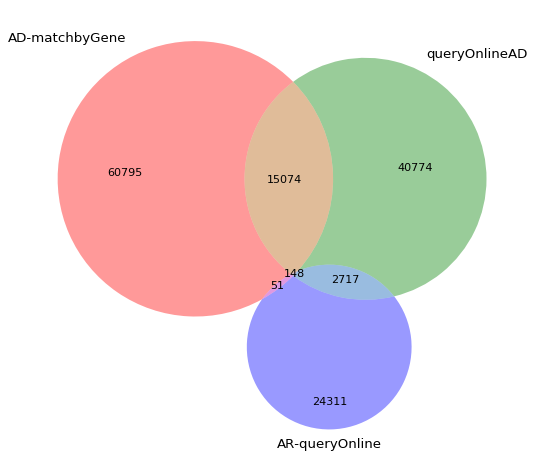

In [3]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
venn3([set(clinvarAD.VariationID.values), set(queryOnlineAD.VariationID.values),set(queryOnlineAR.VariationID.values)],
      set_labels = ('AD-matchbyGene', 'queryOnlineAD','AR-queryOnline'))

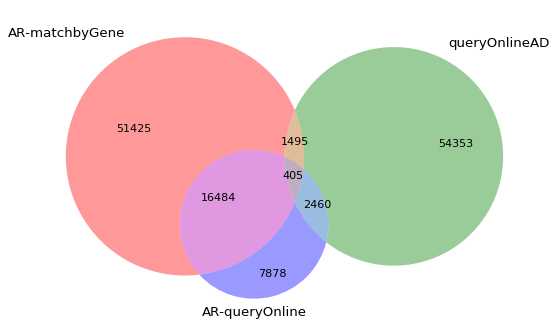

In [4]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
venn3([set(clinvarAR.VariationID.values), set(queryOnlineAD.VariationID.values),set(queryOnlineAR.VariationID.values)],
      set_labels = ('AR-matchbyGene', 'queryOnlineAD','AR-queryOnline'))

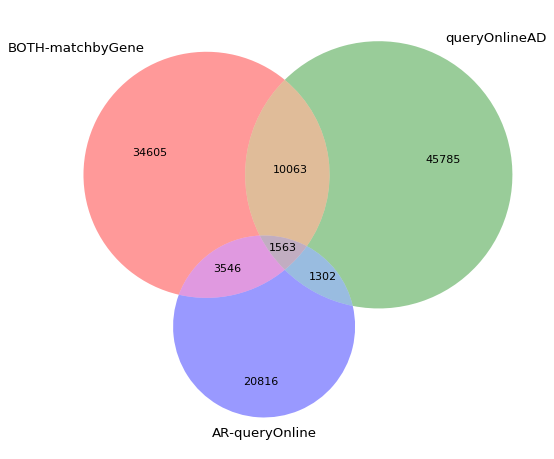

In [5]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
venn3([set(clinvarBOTH.VariationID.values), set(queryOnlineAD.VariationID.values),set(queryOnlineAR.VariationID.values)],
      set_labels = ('BOTH-matchbyGene', 'queryOnlineAD','AR-queryOnline'))

In [8]:
all_bygen = pd.concat([clinvarAD.VariationID,clinvarAR.VariationID,clinvarBOTH.VariationID])
print(all_bygen.nunique())

all_queryOnline = pd.concat([queryOnlineAD.VariationID,queryOnlineAR.VariationID]) 
print(all_queryOnline.nunique())

195654
83075


## Qué características tienen las Dominantes que sólo vemos con el query online?
#### ~3000 (10%) son Paathog o Likely Pathog. 

In [16]:
AD_exclusivas_queryOnline = queryOnlineAD[~queryOnlineAD.VariationID.isin(all_bygen)]
print('total de variantes: %s'%AD_exclusivas_queryOnline.shape[0])
AD_exclusivas_queryOnline['Clinical significance (Last reviewed)'].str.split('(',expand = True).loc[:,0].value_counts().head(10)

total de variantes: 29965


Uncertain significance                                       14478
Likely benign                                                 6908
Pathogenic                                                    2830
Conflicting interpretations of pathogenicity                  2052
Benign/Likely benign                                          1475
Benign                                                        1079
Likely pathogenic                                              868
Pathogenic/Likely pathogenic                                   260
Conflicting interpretations of pathogenicity, risk factor        2
Pathogenic/Likely pathogenic, risk factor                        2
Name: 0, dtype: int64

#### Veamoss algunas de esas 3000 que me pierdo:
* Sólo 422 paprecen tener OMIM id (118 genes).
* 201 vairantes se corresponden a 33 genes que presentan ambos modelos de enfermedad.

In [32]:
lostAD = AD_exclusivas_queryOnline[AD_exclusivas_queryOnline['Clinical significance (Last reviewed)'].str.contains('Pathogenic')]
lostAD['Review status'].value_counts()
lostAD[lostAD['Review status'] == 'criteria provided, multiple submitters, no conflicts'].VariationID.head()

330    264119
504    186150
513    183925
521    201606
555    420072
Name: VariationID, dtype: int64

In [59]:
aver = clinvarTSV[clinvarTSV.VariationID.isin(lostAD.VariationID)]
aver[aver.PhenotypeIDS.str.contains('OMIM')].VariationID.nunique()
aver[(aver.PhenotypeIDS.str.contains('OMIM')) & (aver.GeneID.isin(both_models['Entrez Gene ID']))].VariationID.nunique()

201

## Qué características tienen las Dominantes que sólo vemos matcheando POR GEN?
#### ~15500 (25%) son Paathog o Likely Pathog. 

In [18]:
AD_exclusivas_bygen = clinvarAD[~clinvarAD.VariationID.isin(all_queryOnline)]
print('total variantes: %s'%AD_exclusivas_bygen.shape[0])
AD_exclusivas_bygen.clinsig.value_counts().head()

total variantes: 60795


Uncertain significance    24259
Pathogenic                11968
Likely benign             10720
Likely pathogenic          3422
Benign                     2964
Name: clinsig, dtype: int64

# Inconsistencias

## AD by gene  que son AR por query online (51 variantes) -- pero no en el AD online
* 43 de esas son patogenicas / Likely Path
### ejemplo clinvar ID 205128
* por ejemplo, me meto en la variante con clinvar ID> 205128, figura como disease: Ichthyosis vulgaris AR en condition, pero si vas al gen, te metes en el link de OMIM ves:
* Ichthyosis vulgaris	146700	AD
#### Osea, la inconsistencia persiste. Hay que ver por que la anotaron AR en el campo condition de clinvar. 


### Otro ejemplo: id 7955  
* GLAUCOMA 1, OPEN ANGLE, A, AUTOSOMAL RECESSIVE segun clinvar, y segun omim, pero OMIM mismo pone en el gen correspondiente inheritance AUTOSOMAL DOMINANT

## como sea, no me preocupa tanto por la cantidad. Veamos las inconsistenias de AR que son mas numerosas


In [64]:
ADbygene_ARonline = clinvarAD[(clinvarAD.VariationID.isin(queryOnlineAR.VariationID))&(~clinvarAD.VariationID.isin(queryOnlineAD.VariationID))]
ADbygene_ARonline.VariationID.nunique()

51

In [119]:
'Numero de genens patogenicas: %s'%ADbygene_ARonline['Gene(s)'].nunique()

'Numero de genens patogenicas: 27'

In [77]:
print(ADbygene_ARonline.clinsig.value_counts().head(10))
ADbygene_ARonline.VariationID.head()

Pathogenic                                      32
Likely pathogenic                                7
Uncertain significance                           4
Pathogenic/Likely pathogenic                     4
Conflicting interpretations of pathogenicity     3
Benign                                           1
Name: clinsig, dtype: int64


751       7100
830       4870
2008     39584
3175    208582
3575      7955
Name: VariationID, dtype: int64

## AR by gene  que son AD por query online (1495 variantes) -- pero no estan en el AR online
### che che che, solo 132 son Pathog o Likely Pathog, en 24 genes!!! 
* Entrando en alguunos ejemplossse ve que las inconsistencias residen (al igual que antes) en la doble anotación que presenta OMIM. 
* ej: ID 16005
* El gen correspondiente CSF3R, figura como de herencia AR exclusivamente. Pero si te metes en detalle hay casos dominantes reportados  (0001 NEUTROPHILIA, HEREDITARY (1 family) dominante).



In [70]:
ARbygene_ADonline = clinvarAR[(clinvarAR.VariationID.isin(queryOnlineAD.VariationID))&(~clinvarAR.VariationID.isin(queryOnlineAR.VariationID))]
ARbygene_ADonline.VariationID.nunique()

1495

In [73]:
ARbygene_ADonline.clinsig.value_counts().head(10)

Uncertain significance                          584
Conflicting interpretations of pathogenicity    345
Benign/Likely benign                            182
Likely benign                                   160
Benign                                           90
Pathogenic                                       77
Pathogenic/Likely pathogenic                     28
Likely pathogenic                                27
drug response                                     1
not provided                                      1
Name: clinsig, dtype: int64

In [117]:
ARbygene_ADonline_pathog = ARbygene_ADonline[ARbygene_ADonline.clinsig.isin(['Pathogenic','Pathogenic/Likely pathogenic','Likely pathogenic'])]
'Numero de inconsistencias patogenicas: %s'%ARbygene_ADonline_pathog.shape[0]

'Numero de inconsistencias patogenicas: 132'

In [118]:
'Numero de genens patogenicas: %s'%ARbygene_ADonline_pathog['Gene(s)'].nunique()

'Numero de genens patogenicas: 24'

In [114]:
# ejemplos de variantes
ARbygene_ADonline_pathog.groupby(['Gene(s)'])['VariationID'].head(1)

70       236063
2775      16005
3246     238337
5540     427946
8700      14278
17864      2779
20899      1005
21929      7030
26405    225048
26778    215055
28254    225028
28422     91343
32009    185026
33143    225021
36971     12044
41840     68738
47712    208729
51622      7497
52236    242391
58729    280534
60489    182847
61095    139604
65915    206424
67048    161096
Name: VariationID, dtype: int64

# BOTH models

In [ ]:
fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
venn3([set(clinvarBOTH.VariationID.values), set(queryOnlineAD.VariationID.values),set(queryOnlineAR.VariationID.values)],
      set_labels = ('AD-matchbyGene', 'queryOnlineAD','AR-queryOnline'))